In [1]:
import requests
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import h5py
import gizmo_analysis as gizmo
import halo_analysis as halo
import utilities as ut
import os
from astropy import units as u

In [2]:
# replace with simulation directory
# simulation_directory = '/home/zimi/analysis/FIRE/m12i_res7100/'
simulation_directory = '/pool001/zimi/analysis/FIRE/m12f_res7100/'

# Get gas data

In [3]:
# Read gas particles at z = 0, store as a python dictionary
part = gizmo.io.Read.read_snapshots(['gas'], 'redshift', 0, simulation_directory, assign_hosts='halo', assign_hosts_rotation=True)


# in utilities.simulation.Snapshot():
* reading:  pool001/zimi/analysis/FIRE/m12f_res7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  pool001/zimi/analysis/FIRE/m12f_res7100/output/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 96239056 particles
    dark2     (id = 2): 7591203 particles
    gas       (id = 0): 80307825 particles
    star      (id = 4): 16066489 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['gas']

* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

* reading cosmological parameters from:  pool001/zimi/analysis/FIRE/m12f_res7100/initial_condition/ic_agora_m12f.conf

* checking sanity of particle properties
! warning: gas id.child [min, max] = [0.000, 4.281e9]
! warning: gas mass [min, med, max] = [7067.277

In [4]:
part['gas'].keys()

dict_keys(['position', 'density', 'electron.fraction', 'temperature', 'mass', 'massfraction', 'hydrogen.neutral.fraction', 'id.child', 'id.generation', 'id', 'potential', 'size', 'sfr', 'velocity'])

In [5]:
host = part.host
host_pos = host['position']

In [6]:
gas = part['gas']
positions = gas['position']
x = positions[:,0]
y = positions[:,1]
z = positions[:,2]

dist = gas.prop('host.distance.principal')
dist_x = dist[:,0]
dist_y = dist[:,1]
dist_z = dist[:,2]
dist_tot = gas.prop('host.distance.total')


In [7]:
dens = gas['density']
ne = gas['electron.fraction']*gas.prop('hydrogen.number.density') # units:cm^-3
binsize = gas['size']
temp = gas['temperature']
potential = gas['potential']

In [7]:
# get cooling data
cooling_dir = '/pool001/alanman/analysis/FIRE/m12f_res7100/output/'

# fh = h5py.File("/pool001/alanman/analysis/FIRE/m12f_res7100/output/cooling_600.0.hdf5", 'r')     # First part of the snapshot for m12f

cooling_times = []
cooling_rates = []

for file in os.listdir(cooling_dir):
    fh = h5py.File(os.path.join(cooling_dir, file), 'r')
    
    cooling_time_seconds = fh['Ambient/time'][()] * fh['Ambient/time'].attrs['to_cgs']     # Cooling times in seconds
    cooling_rate_cgs = fh['Ambient/rate'][()] * fh['Ambient/rate'].attrs['to_cgs']    # Cooling rate in erg sec^-1 cm^3

    cooling_times.append(cooling_time_seconds)
    cooling_rates.append(cooling_rate_cgs)

cooling_times = np.concatenate(cooling_times)
cooling_rates = np.concatenate(cooling_rates)

In [16]:
# make pandas dataframe
data = {'x': x,
        'y': y,
        'z': z,
        'dist_x': dist_x,
        'dist_y':dist_y,
        'dist_z': dist_z,
        'dist_tot': dist_tot,
        'density': dens,
        'n_e': ne,
        'smoothing_len': binsize,
        'cooling_rate' : cooling_rates,
        'cooling_time' : cooling_times,
        'internal_energy': temp,
        'potential': potential}
gas_df = pd.DataFrame(data)


# Get primary halo

In [17]:
# read a halo catalog at single snapshot (z = 0)
hal = halo.io.IO.read_catalogs('redshift', 0, simulation_directory, species='gas')


# in utilities.simulation.Snapshot():
* reading:  pool001/zimi/analysis/FIRE/m12f_res7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000

* read 59085 halos from:  pool001/zimi/analysis/FIRE/m12f_res7100/halo/rockstar_dm/catalog_hdf5/halo_600.hdf5

# in halo_analysis.halo_io.Particle():
! cannot find halo file:  pool001/zimi/analysis/FIRE/m12f_res7100/halo/rockstar_dm/catalog_hdf5/gas_600
* assigning primary host and coordinates wrt it to halo catalog...  finished



In [18]:
host_index = hal['host.index'][0]
host_radius = hal['radius'][host_index]

In [19]:
# select only gas in halo
mask = (gas_df['dist_tot'] <= host_radius)
halo_gas = gas_df[mask]

# Plot

In [20]:
def plot2d(x, y, value, cmap = 'viridis', norm = None, vmin = None, vmax = None, **kwargs):
    counts, xbins, ybins = np.histogram2d(x, y, **kwargs)
    sums, _, _ = np.histogram2d(x, y, weights = value, **kwargs)

    with np.errstate(divide='ignore', invalid='ignore'):  # suppress possible divide-by-zero warnings
        plot = plt.pcolormesh(ybins, xbins, sums / counts, cmap = cmap, norm = norm, vmin = vmin, vmax = vmax)

    return plot

# Shattering plots

Text(0.5, 1.0, 'm12f')

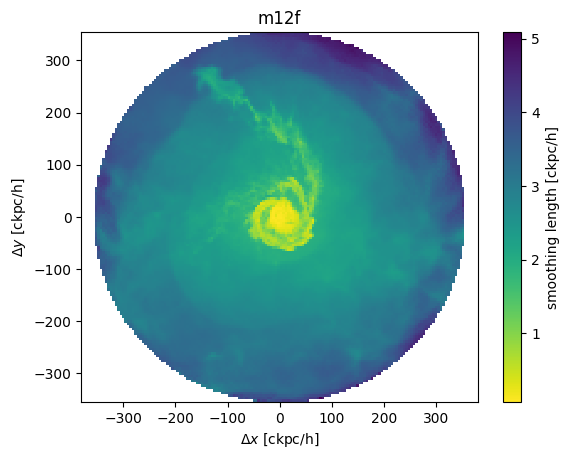

In [14]:
# plot binsize
binsize_plot = plot2d(halo_gas['dist_x'], halo_gas['dist_y'], value = halo_gas['smoothing_len'], cmap = 'viridis_r', bins = [150,150])

plt.xlabel('$\Delta x$ [ckpc/h]')
plt.ylabel('$\Delta y$ [ckpc/h]')
plt.axis('equal')
plt.colorbar(binsize_plot, label = 'smoothing length [ckpc/h]')
plt.title('m12f')

In [21]:
gamma = 5/3
c_s = np.sqrt(gamma*(gamma-1)*halo_gas['internal_energy'])
t_cross = halo_gas['smoothing_len']*3.09e16/c_s
t_cool = halo_gas['cooling_time']

# freefall time
t_ff = (2*halo_gas['dist_tot']*3.086e16/3)*np.sqrt(-1/halo_gas['potential'])

In [22]:
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.colormaps.register(cmap=newcmap)

    return newcmap

In [23]:
orig_cmap = matplotlib.cm.seismic
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=0.5, name='shifted5')

In [23]:
shatter_mask = ((t_ff/t_cross) < 1)
location_mask = (halo_gas['dist_z'] <= 1)

In [24]:
halo_masked = halo_gas[location_mask]

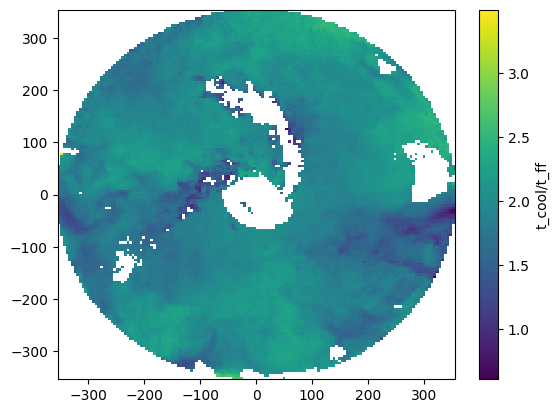

In [30]:
plot2d(halo_masked['dist_x'], halo_masked['dist_y'], value = np.log10(-((t_cool)/(t_ff)))[location_mask], bins = [150,150])
cbar = plt.colorbar()
cbar.set_label('t_cool/t_ff')


In [25]:
halo_gas.keys()

Index(['x', 'y', 'z', 'dist_x', 'dist_y', 'dist_z', 'dist_tot', 'density',
       'n_e', 'smoothing_len', 'cooling_rate', 'cooling_time',
       'internal_energy', 'potential'],
      dtype='object')

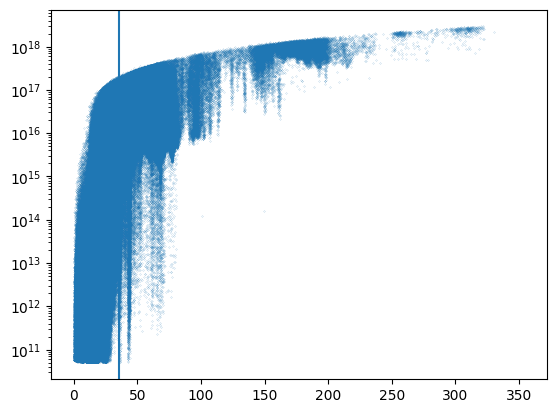

In [32]:
plt.scatter(halo_gas['dist_tot'][mask], (c_s*t_cool)[mask], s = 0.01)
plt.axvline(x = host_radius*0.1)
plt.yscale("log")

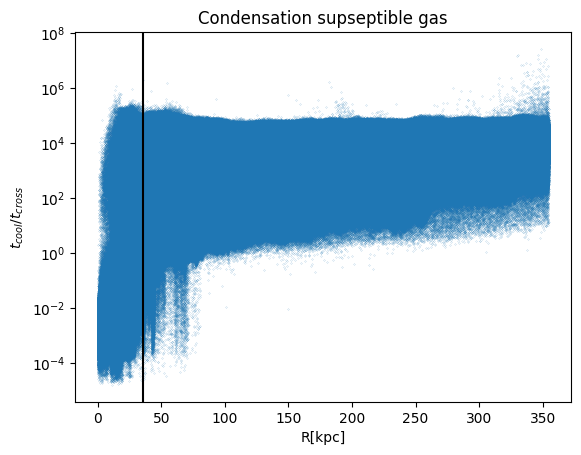

In [35]:
plt.scatter(halo_gas['dist_tot'], (np.abs(t_cool)/t_cross), s = 0.01)
plt.yscale("log")
plt.xlabel('R[kpc]')
plt.title("Condensation supseptible gas")
plt.ylabel(r'$t_{cool}/t_{cross}$')
plt.axvline(x = host_radius*0.1, c = 'k')

# Perform ray trace

In [12]:
# get particles that intersect with ray
# ray only in z direction

halo_binsize = halo_gas['bin_size']
ray_location = np.asarray([0,0])

line = halo_gas[['dist_x', 'dist_y']] - ray_location

dist = np.linalg.norm(line, axis = 1)
halo_gas['dist_ray'] = dist

mask = (dist < halo_binsize)
gas_intersect = halo_gas[mask]


/home/zimi/frb_scattering/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


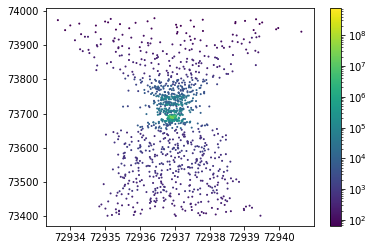

In [108]:
part = plt.scatter(gas_intersect['x'], gas_intersect['z'], c=gas_intersect['density'], s = 1, norm=matplotlib.colors.LogNorm())
plt.colorbar(part)
    

In [13]:
# get chord length 
# chord_len should have units of kpc
gas_intersect['chord_len'] = 2*np.sqrt(gas_intersect['bin_size']**2-gas_intersect['dist_ray']**2)

/home/zimi/frb_scattering/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
dm = np.sum(gas_intersect['chord_len']*gas_intersect['n_e'])
dm

2.909482541898198

In [89]:
from astropy import units as u

d = dm*u.kpc**-2
d

<Quantity 1.69920971e+75 1 / kpc2>

In [90]:
d.to(u.kpc/(u.cm**3))

<Quantity 5.78356133e+10 kpc / cm3>

Text(0.5, 0, 'ckpc/h')

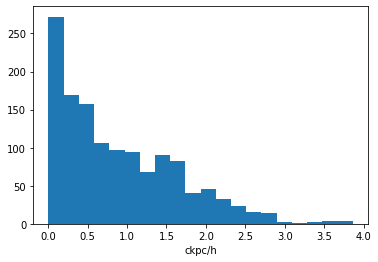

In [96]:
plt.hist(gas_intersect['dist_ray'], bins = 20)
plt.xlabel('ckpc/h')